<a href="https://colab.research.google.com/github/hookskl/nlp_w_pytorch/blob/main/nlp_w_pytorch_cnn_surnames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell

# get python file shell script
curl -o download.py https://raw.githubusercontent.com/hookskl/PyTorchNLPBook/master/data/download.py
#! /bin/bash

# For each file, add a download.py line
# Any additional processing on the downloaded file

HERE="$( cd "$( dirname "${BASH_SOURCE[0]}" )" && pwd )"

# Surnames Dataset
mkdir -p $HERE/surnames
if [ ! -f $HERE/surnames/surnames_with_splits.csv ]; then
    python download.py 1T1la2tYO1O7XkMRawG8VcFcvtjbxDqU- $HERE/surnames/surnames_with_splits.csv # 8
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1572  100  1572    0     0  18939      0 --:--:-- --:--:-- --:--:-- 18939


## Imports

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

## Vocabulary

In [3]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token

        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)

    def to_serializable(self):
        """returns a dictionary that can be serialized"""
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """instantiates the Vocabulary from a serialized dictionary"""
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index 
            self._idx_to_token[index] = token
        return index 

    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK the index if token isn't present.

        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

## Vectorizer

In [4]:
class SurnameVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)

        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1

        return one_hot_matrix

    @classmethod 
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab, max_surname_length)

    @classmethod 
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab = Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab, 
                   max_surname_length=contents['max_surname_length'])
        
    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable(),
                'max_surname_length': self._max_surname_length}

## SurnameDataset

In [5]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df: (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instantiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer.
        Used in the case in the vectorizer has been cached for re-use

        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file

        Args:
            vectorizer_filepath (str): the location the serialized vectorizer
        Returns:
            an instance of the SurnameDataset
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json

        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """returns the vectorizer"""
        return self._vectorizer 

    def set_split(self, split="train"):
        """selects the splits in the dataset using the column in the dataframe"""
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size 
    
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix, 
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset

        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size 
      





## Batch Generator

In [6]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the right device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)
    
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## CNN

In [7]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels, dropout_p):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()

        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels,
                      out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.BatchNorm1d(num_features=num_channels),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.BatchNorm1d(num_features=num_channels),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.BatchNorm1d(num_features=num_channels),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3),
            nn.ELU(),
            nn.BatchNorm1d(num_features=num_channels)
        )
        
        self.fc1 = nn.Linear(num_channels, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x_surname, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_surname (torch.Tensor): an input data tensor
              x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax(bool): a flag for the softmax activation
        Returns:
            the resulting tensor.
              tensor.shape should be (batch, num_classes)
        """
        features = self.convnet(x_surname).squeeze(dim=2)
        x = F.relu(self.fc1(features))
        x = self.dropout(x)
        prediction_vector  = self.fc2(x)

        

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training

### Make Train State

In [8]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

### Update Train State

In [9]:
def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

### Compute Accuracy

In [10]:
def compute_accuracy(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

### Define args

In [11]:
args = Namespace(
    # Data and Path information
    surname_csv="surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/cnn",
    # Model hyper parameters
    hidden_dim=100,
    num_channels=256,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=25,
    early_stopping_criteria=5,
    dropout_p=0.3,
    # Runtime options
    cuda=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch4/cnn/vectorizer.json
	model_storage/ch4/cnn/model.pth
Using CUDA: True


### Instantiations

In [12]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels,
                               dropout_p=args.dropout_p)

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

### Training Loop

In [13]:
# progress bars for training and validation sets
epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index 

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0.0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine 

            # ---------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to update model weights
            optimizer.step()
            # ---------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0.0, set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                           batch_size=args.batch_size,
                                           device=args.device)
        
        running_loss = 0.0
        running_acc = 0.0
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc,
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)
        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


### Testing

In [14]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

## Visualize Loss Over Time

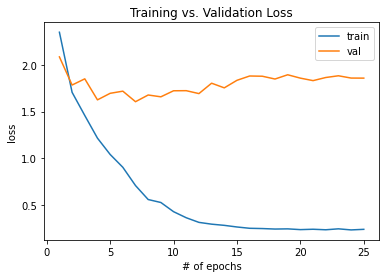

In [15]:
x = [epoch + 1 for epoch in range(args.num_epochs)]
loss_train = train_state['train_loss']
loss_val = train_state['val_loss']

plt.plot(x, loss_train, label='train')
plt.plot(x, loss_val, label='val')
plt.xlabel('# of epochs')
plt.ylabel('loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [16]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.8186815083026886;
Test Accuracy: 68.81510416666667


## Inference

### Predict Nationality

In [17]:
def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname

    Args:
        surname (str): the surname to classify
        classifier (SurnameClassifier): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}

In [18]:
new_surname = input("Enter a surname to classify: ")
classifier = classifier.cpu()
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

Enter a surname to classify: Hooks
Hooks -> Czech (p=0.48)


### Predict Top k Nationality

In [19]:
def predict_topk_nationality(surname, classifier, vectorizer, k=5):
    """Predict the top K nationalities from a new surname

    Args:
        surname (str): the surname to classify
        classifier (SurnameClassifier): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        k (int): the number of top nationalities to return
    Returns:
        list of dictionaries, each dictionary is a nationality and a probability
    """

    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    prediction_vector = classifier(vectorized_surname, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)

    # returned size is 1,k
    probability_values = probability_values[0].detach().numpy()
    indices = indices[0].detach().numpy()

    results = []
    for kth_index in range(k):
        nationality = vectorizer.nationality_vocab.lookup_index(indices[kth_index])
        probability_value = probability_values[kth_index]
        results.append({'nationality': nationality,
                        'probability': probability_value})
    return results



In [20]:
new_surname = input("Enter a surname to classify: ")
k = int(input("How many of the top predictions to see? "))
if k > len(vectorizer.nationality_vocab):
    print("Sorry! That's more than the # of nationalities we have... defaulting to max size.")
    k = len(vectorizer.nationality_vocab)

predictions = predict_topk_nationality(new_surname, classifier, vectorizer, k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_surname,
                                        prediction['nationality'],
                                        prediction['probability']))

Enter a surname to classify: Hooks
How many of the top predictions to see? 4
Top 4 predictions:
Hooks -> Czech (p=0.48)
Hooks -> English (p=0.28)
Hooks -> German (p=0.20)
Hooks -> Dutch (p=0.03)
